# Analisi esplorativa del dataset

Il dataset “10 000+ Popular TV Shows Dataset (TMDb)” raccoglie oltre 10.000 serie televisive popolari tratte da The Movie Database (TMDb), corredate da metadati quali titolo originale, lingua, paese d’origine, sinossi, data di prima messa in onda, popolarità numerica, voto medio, numero di voti e percorsi di immagini. Offre un’ampia base per analisi esplorative, elaborazione del linguaggio naturale e sistemi di raccomandazione nel contesto delle serie TV.

Source: [📺 10,000+ Popular TV Shows Dataset (TMDB)](https://www.kaggle.com/datasets/riteshswami08/10000-popular-tv-shows-dataset-tmdb)

## Fase Preliminare: Pulizia e Arricchimento dei Dati

Prima di procedere con l'analisi esplorativa e il feature engineering in questo notebook, è stata condotta una fase preliminare fondamentale di pulizia e arricchimento dei dati.

L'analisi iniziale del dataset grezzo ha rivelato la presenza di un numero significativo di valori mancanti in colonne critiche, in particolare nella feature "overview" (oltre 900 righe, pari a circa il 10% del dataset). La semplice rimozione di queste righe avrebbe comportato una perdita sostanziale di informazioni (circa il 10%). Per ovviare a questo problema, sono state utilizzate fonti esterne tramite API:

1.  Recupero da TMDB (fonte ufficiale del dataset): Per ogni riga con "overview" mancante, è stata interrogata l'API di TMDB utilizzando l'ID univoco.

2.  Recupero da OMDb (seconda fonte): Per i casi in cui TMDB non ha fornito risultati, è stato recuperato l'IMDb ID della serie (sempre tramite API TMDB). Questo  è stato poi utilizzato per interrogare l'API di OMDb.

3.  **Pulizia Finale:** Solo al termine di questo processo a cascata, le poche righe per cui non è stato possibile recuperare una sinossi sono state rimosse.

Questo approccio a più livelli ha permesso di **ridurre drasticamente la perdita di dati**, passando da oltre 900 righe a rischio a un numero trascurabile, garantendo un dataset di partenza molto più completo e di alta qualità. Il file `filled_final.csv`, caricato di seguito, è il risultato di questa fase di preparazione.

## Analisi

Caricamento dataset:

In [1753]:
import pandas as pd

df = pd.read_csv("data/filled_final.csv")

| Column            | Type              | Missing % | Description                                                                                                           | Example                          |
|--------------------|------------------|------------|-----------------------------------------------------------------------------------------------------------------------|----------------------------------|
| adult              | int / bool        | 0.00%      | Adult-content flag (0 = no, 1 = yes).                                                                                 | 0                                |
| backdrop_path      | string            | 6.83%      | Relative path to the backdrop image (nullable).                                                                       | /gR7GmFJ0lCFqtv8h2yDfzX3ojx0.jpg |
| genre_ids          | list-like string  | 0.00%      | Genre IDs stored as a list-like string (e.g. `"[18, 35]"`). Parse with `ast.literal_eval` to get a list of ints.      | "[18, 35]"                       |
| id                 | int               | 0.00%      | Canonical integer id for the show — use as primary key when merging.                                                  | 1399                             |
| origin_country     | list-like string  | 0.00%      | Country code(s) stored as a list-like string (e.g. `['US']`). Parse before grouping.                                  | "['US']"                         |
| original_language  | string            | 0.00%      | ISO language code of the original show (e.g. `en`, `ja`).                                                             | en                               |
| original_name      | string            | 0.00%      | Original title in the original language.                                                                              | Breaking Bad                     |
| overview           | string            | 9.27%      | Short synopsis/summary of the show (nullable). Great for NLP.                                                         | A high school chemistry teacher... |
| popularity         | float             | 0.00%      | Numeric popularity score (float). Useful as a proxy for demand.                                                       | 123.456                          |
| poster_path        | string            | 2.47%      | Relative path to the poster image (nullable).                                                                         | /abc123poster.jpg                |
| first_air_date     | date (string)     | 0.34%      | Release / first air date. Convert to datetime; note some future dates (~2025).                                        | 2013-01-20                       |
| name               | string            | 0.00%      | Common/English title (not guaranteed unique).                                                                         | Game of Thrones                  |
| vote_average       | float             | 0.00%      | Mean user rating (float). Consider filtering by `vote_count`.                                                         | 8.6                              |
| vote_count         | int               | 0.00%      | Number of votes (int). Use to filter reliable ratings (e.g., >= 10).                                                  | 12534                            |


Info generali:

In [1754]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9209 entries, 0 to 9208
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   adult              9209 non-null   bool   
 1   backdrop_path      8696 non-null   object 
 2   genre_ids          9209 non-null   object 
 3   id                 9209 non-null   int64  
 4   origin_country     9209 non-null   object 
 5   original_language  9209 non-null   object 
 6   original_name      9209 non-null   object 
 7   overview           9209 non-null   object 
 8   popularity         9209 non-null   float64
 9   poster_path        9036 non-null   object 
 10  first_air_date     9186 non-null   object 
 11  name               9209 non-null   object 
 12  vote_average       9209 non-null   float64
 13  vote_count         9209 non-null   int64  
 14  imdb_id            382 non-null    object 
dtypes: bool(1), float64(2), int64(2), object(10)
memory usage: 1016.4+ KB


In [1755]:
df.describe()

,id,popularity,vote_average,vote_count
count,9209.000000,9209.000000,9209.000000,9209.000000
mean,87365.860571,8.030712,6.716418,244.378326
std,80689.917642,10.896909,2.076943,896.355889
min,6.000000,1.768100,0.000000,0.000000
25%,18222.000000,3.718200,6.300000,6.000000
50%,67229.000000,4.988700,7.200000,28.000000
75%,117884.000000,8.208400,7.900000,141.000000
max,300369.000000,318.781200,10.000000,25527.000000


Feature da eliminare (id e metadati vari)
- id: si tratta di un identificatore univoco che non ha alcun valore predittivo (rimossa solo per il training)
- name & original_name: identificatore testuale ad altissima cardinalità, segnale rumoroso
- backdrop_path & poster_path: l'informazione sarebbe nel file piuttosto, non nel percorso
- imdb_id: utilizzato solo in fase di information retrieval

In [1756]:
df = df.drop(labels=['name', 'original_name', 'backdrop_path', 'poster_path', 'imdb_id'], axis=1)

In [1757]:
print("FEATURES: " + str(list(df.columns)))
print("# FEATURES: " + str(len(df.columns)))
print("rows: " + str(len(df)))

FEATURES: ['adult', 'genre_ids', 'id', 'origin_country', 'original_language', 'overview', 'popularity', 'first_air_date', 'vote_average', 'vote_count']
# FEATURES: 10
rows: 9209


Verifica dei duplicati

In [1758]:
df[df.duplicated(keep=False)]

,adult,genre_ids,id,origin_country,original_language,overview,popularity,first_air_date,vote_average,vote_count


Righe dopo la rimozione dei duplicati:

In [1759]:
df = df.drop_duplicates()
print("rows: " + str(len(df)))

rows: 9209


Bisogna considerare che in determinate feature (genre_ids, origin_country) i valori "[]" sono da considerare null

In [1760]:
import numpy as np
df['genre_ids'] = df['genre_ids'].replace('[]', np.nan)
df['origin_country'] = df['origin_country'].replace('[]', np.nan)


Conteggio dei valori nulli:

In [1761]:
df.isnull().sum().sort_values(ascending=False)

genre_ids            167
origin_country        25
first_air_date        23
adult                  0
id                     0
original_language      0
overview               0
popularity             0
vote_average           0
vote_count             0
dtype: int64

Su queste righe con valori null si potrebbe applicare la stessa tecnica applicata per la feature "overview".
Per semplicità, fato che le righe con valori nulli rappresentavano una piccola frazione del dataset, le scartiamo.

In [1762]:
df = df.dropna()
print("righe totali: "+str(len(df)))
print("feature: "+str(len(df.columns)))

righe totali: 9012
feature: 10


### Analisi della variabile target "vote_average"

In [1763]:
print(df['vote_average'].describe())

count    9012.000000
mean        6.774161
std         1.995785
min         0.000000
25%         6.400000
50%         7.295500
75%         7.900000
max        10.000000
Name: vote_average, dtype: float64


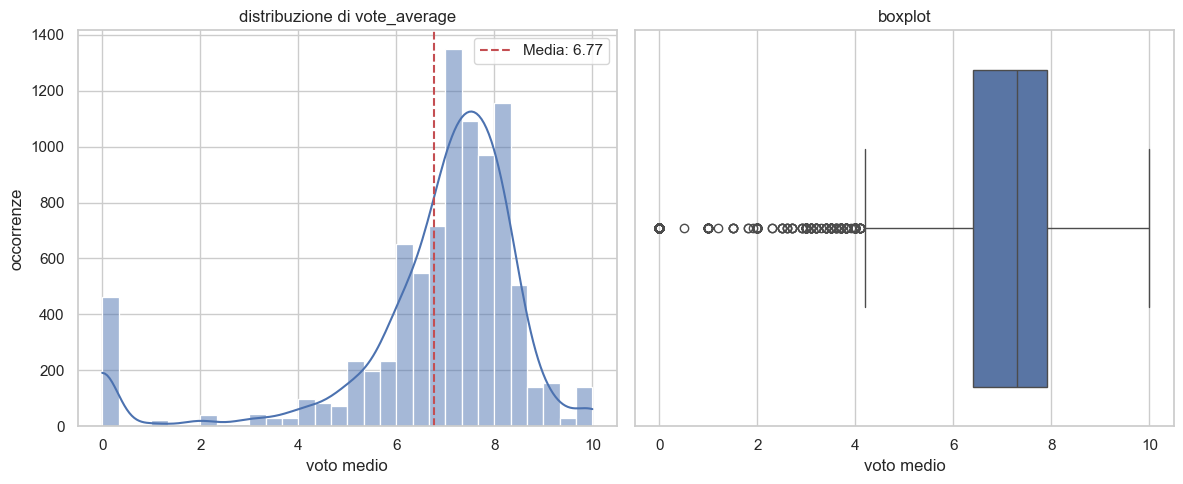

In [1764]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['vote_average'], kde=True, bins=30)
plt.title('distribuzione di vote_average')
plt.xlabel('voto medio')
plt.ylabel('occorrenze')
# Aggiunge una linea verticale per la media
plt.axvline(df['vote_average'].mean(), color='r', linestyle='--', label=f"Media: {df['vote_average'].mean():.2f}")
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x=df['vote_average'])
plt.title('boxplot')
plt.xlabel('voto medio')

plt.tight_layout()
plt.show()

In [1765]:
zero_votes_df = df[df['vote_average'] == 0]
zero_votes_df['vote_count'].describe()

count    463.000000
mean       0.012959
std        0.113220
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: vote_count, dtype: float64

osservazioni principali:
- L'istogramma mostra una distribuzione che non è normale e presenta due "campane": una per vote_average = 0 e una più tradizionale attorno a 7.5/8
- Per i voti con un vote_average di 0, la media del numero di voti è praticamente nulla. Quindi il vote_average = 0 non rappresenta una pessima qualità del programma, ma indica semplicemente l'assenza di voti. Questi dati agiscono come rumore.
- Escludendo il picco a zero, la maggior parte dei voti si concentra nella parte alta della scala.
- Gli outlier in questo caso rappresentano gli esempi di qualità bassa quindi non va effettuata rimozione.

Procediamo quindi alla rimozione delle righe con vote_average = 0.

In [1766]:
initial_rows = len(df)
df = df[df['vote_average'] > 0]
final_rows = len(df)
print(f"righe rimosse: {initial_rows - final_rows}")

righe rimosse: 463


### Feature "genre_ids"
1. Parsing: trasformare la stringa "[1,2,3]" in una vera lista Python [1,2,3]
2. Creazione di num_genres: feature numerica, con probabile correlazione con la variabile target
3. One-Hot Encoding semplificato: ho estratto i generi più importanti e li ho trasformati in feature binarie

In [1767]:
import ast
df['genre_ids'] = df['genre_ids'].apply(ast.literal_eval)

In [1768]:
df['num_genres'] = df['genre_ids'].apply(len)
print(df[['num_genres', 'genre_ids']].head())

   num_genres          genre_ids
0           3  [10765, 9648, 35]
1           1               [18]
2           2        [10765, 18]
3           3     [80, 18, 9648]
4           3     [80, 18, 9648]


In [1769]:
print(df['num_genres'].describe())

count    8549.000000
mean        2.233244
std         1.080462
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: num_genres, dtype: float64


Dopo aver creato questa feature, abbiamo notato che la correlazione è di circa 0.2 (debole). Questo indica una correlazione positiva debole. Quindi non si tratta sicuramente di una relazione lineare tra le due feature.
Però, dal boxplot, possiamo notare come i programmi TV con un solo genere hanno un voto medio tendenzialmente più basso rispetto ai programmi multi-genere. Quindi si può confermare che la feature ha un certo valore predittivo.

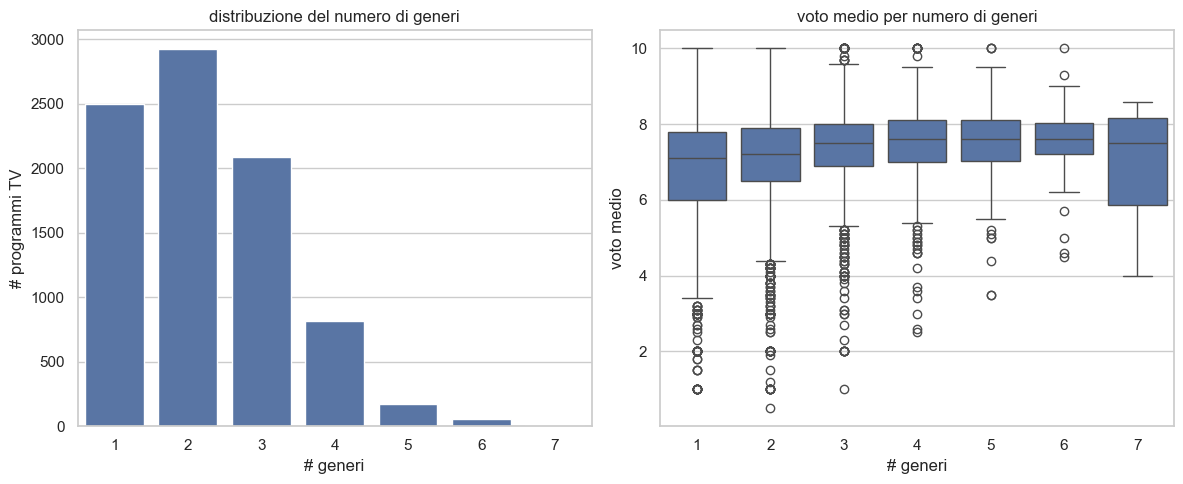

              num_genres  vote_average
num_genres      1.000000      0.168373
vote_average    0.168373      1.000000


In [1770]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='num_genres', data=df)
plt.title('distribuzione del numero di generi')
plt.xlabel('# generi')
plt.ylabel('# programmi TV')

plt.subplot(1, 2, 2)
sns.boxplot(x='num_genres', y='vote_average', data=df)
plt.title('voto medio per numero di generi')
plt.xlabel('# generi')
plt.ylabel('voto medio')

plt.tight_layout()
plt.show()

# Possiamo anche vedere la correlazione numerica
correlation = df[['num_genres', 'vote_average']].corr()
print(correlation)


Dall'analisi della feature num_genres, ho osservato che le categorie con 5 o più generi erano scarsamente popolate. Per creare feature più robuste e ridurre il rumore, ho raggruppato queste categorie in un unico '5+'. Decido di utilizzare quindi le categorie "1","2","3","4","5+". Di seguito viene applicato il one-hot encoding.

In [1771]:
df['num_genres'] = np.where(df['num_genres'] >= 5, '5+', df['num_genres'].astype(str))
df['num_genres'].value_counts()

num_genres
2     2921
1     2493
3     2086
4      816
5+     233
Name: count, dtype: int64

In [1772]:
num_genres_encoded = pd.get_dummies(df['num_genres'], prefix='num_genres', dtype=int)
df = pd.concat([df, num_genres_encoded], axis=1)
df = df.drop(labels=['num_genres'], axis=1)
num_genres_encoded

,num_genres_1,num_genres_2,num_genres_3,num_genres_4,num_genres_5+
0,0,0,1,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
9204,0,1,0,0,0
9205,1,0,0,0,0
9206,1,0,0,0,0
9207,1,0,0,0,0


Dopo aver analizzato il numero di generi, concentriamoci sull'informazione relativa a quali specifici generi sono associati a un programma TV. questo perchè l'analisi precedente ha mostrato che il voto medio varia significativamente in base al genere

Per evitare un'eccessiva dimensionalità, applicheremo il one-hot encoding solo ai 10 generi più comuni nel dataset.

In [1773]:
from collections import Counter
all_genre_ids = [genre_id for sublist in df['genre_ids'] for genre_id in sublist]
genre_id_counts = Counter(all_genre_ids)
genre_counts_df = pd.DataFrame(genre_id_counts.items(), columns=['genre_id', 'count'])
genre_counts_df = genre_counts_df.sort_values('count', ascending=False)
print(genre_counts_df.head(10))

    genre_id  count
3         18   4588
2         35   3140
6         16   2173
5      10759   1891
0      10765   1873
4         80   1115
1       9648    951
7      10751    898
12     10762    675
14     10764    470


In [1774]:
top_genre_ids = genre_counts_df['genre_id'].head(10).tolist()
for genre_id in top_genre_ids:
    col_name = f'genre_id_{genre_id}'
    # la colonna sarà 1 se l'ID del genere è nella lista di generi della serie altrimenti 0
    df[col_name] = df['genre_ids'].apply(lambda genres: 1 if genre_id in genres else 0)
new_genre_cols = [f'genre_id_{gid}' for gid in top_genre_ids]
df = df.drop(['genre_ids'], axis=1)
print(df[['id'] + new_genre_cols].head())

       id  genre_id_18  genre_id_35  genre_id_16  genre_id_10759  \
0  119051            0            1            0               0   
1  194766            1            0            0               0   
2  157239            1            0            0               0   
3    1405            1            0            0               0   
4    2734            1            0            0               0   

   genre_id_10765  genre_id_80  genre_id_9648  genre_id_10751  genre_id_10762  \
0               1            0              1               0               0   
1               0            0              0               0               0   
2               1            0              0               0               0   
3               0            1              1               0               0   
4               0            1              1               0               0   

   genre_id_10764  
0               0  
1               0  
2               0  
3               0  
4   

### Feature "adult"

In [1775]:
df['adult'].value_counts()

adult
False    8549
Name: count, dtype: int64

Ci accorgiamo che ha un valore costante quindi la droppiamo.

In [1776]:
df = df.drop('adult', axis=1)

### Feature "first_air_date"

Si tratta di una feature ad altissima cardinalità quindi bisogna prestare molta attenzione

Vediamo come può influenzare il vote_average

In [1777]:
df['first_air_date'] = pd.to_datetime(df['first_air_date'])
df['release_year'] = df['first_air_date'].dt.year
df['release_year'] = df['release_year'].astype(int)
print(df[['first_air_date', 'release_year']].head())

  first_air_date  release_year
0     2022-11-23          2022
1     2022-06-16          2022
2     2025-08-12          2025
3     2006-10-01          2006
4     1999-09-20          1999


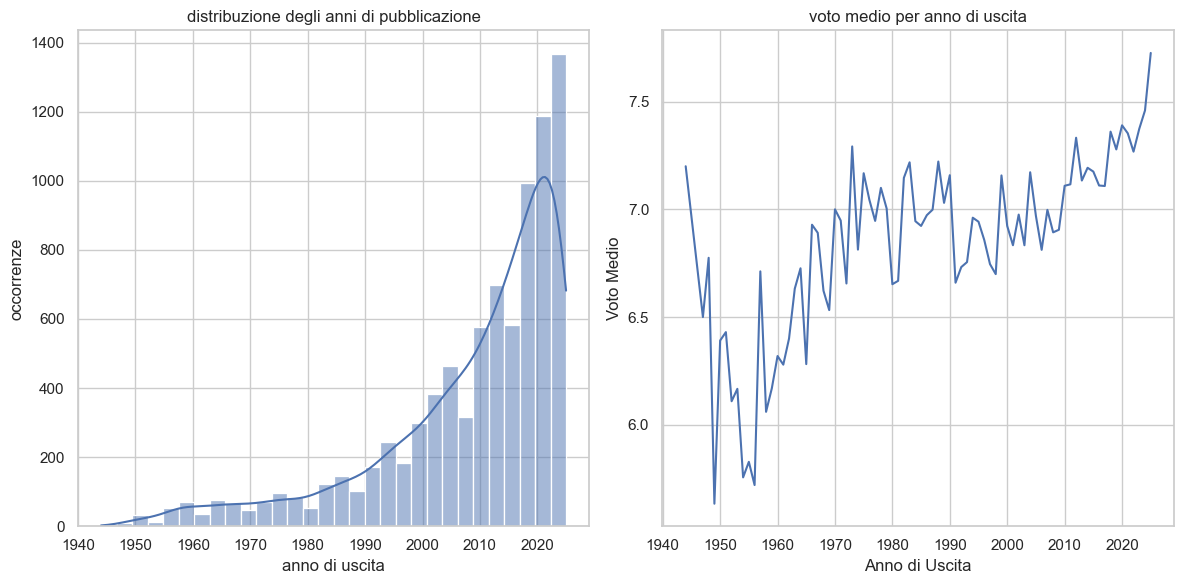

In [1778]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['release_year'], bins=30, kde=True)
plt.title('distribuzione degli anni di pubblicazione')
plt.xlabel('anno di uscita')
plt.ylabel('occorrenze')

plt.subplot(1, 2, 2)
yearly_avg_vote = df.groupby('release_year')['vote_average'].mean()
yearly_avg_vote.plot(kind='line')
plt.title('voto medio per anno di uscita')
plt.xlabel('Anno di Uscita')
plt.ylabel('Voto Medio')
plt.grid(True)

plt.tight_layout()
plt.show()

In [1779]:
correlation = df[['release_year', 'vote_average']].corr()
print(correlation)

              release_year  vote_average
release_year      1.000000      0.190152
vote_average      0.190152      1.000000


Osservazioni:
- dataset sbilanciato verso le serie recenti (è abbastanza ovvio che su quelle si hanno più dati)
- chiaro trend positivo crescente verso le serie recenti rispetto al voto medio recensito
- c'è più sensibilità nei programmi TV del passato, perchè ci sono meno voti

Siamo in un caso molto simile a quello dei generi.

In [1780]:
df = df.drop('first_air_date', axis=1)

### Feaure "origin_country"
approccio di elaborazione simile a quello dei generi

In [1781]:
df['origin_country'] = df['origin_country'].apply(ast.literal_eval)
df['num_countries'] = df['origin_country'].apply(len)
print(df[['num_countries', 'origin_country']].head())

   num_countries origin_country
0              1           [US]
1              1           [US]
2              1           [US]
3              1           [US]
4              1           [US]


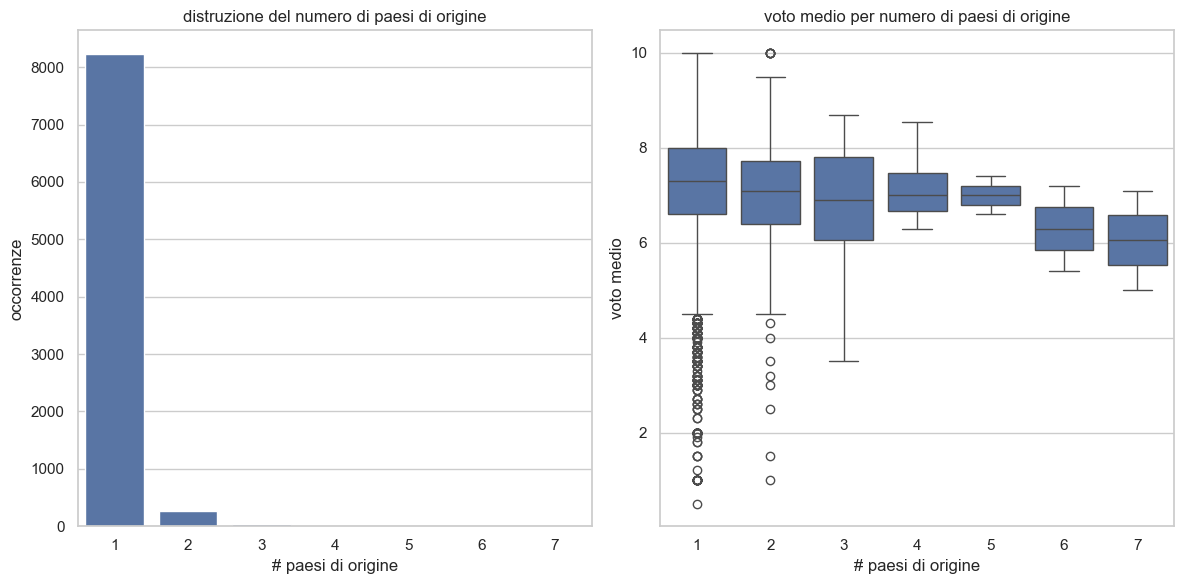

In [1782]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='num_countries', data=df)
plt.title('distruzione del numero di paesi di origine')
plt.xlabel('# paesi di origine')
plt.ylabel('occorrenze')

plt.subplot(1, 2, 2)
sns.boxplot(x='num_countries', y='vote_average', data=df)
plt.title('voto medio per numero di paesi di origine')
plt.xlabel('# paesi di origine')
plt.ylabel('voto medio')

plt.tight_layout()
plt.show()

In [1783]:
correlation = df[['num_countries', 'vote_average']].corr()
print(correlation)

               num_countries  vote_average
num_countries       1.000000     -0.027764
vote_average       -0.027764      1.000000


osservazioni:
- il grafico mostra un dominio schiacciante della categoria 1
- qui non emerge alcun pattern o trend evidente
- distribuzioni dei voti per 1, 2 o 3 paesi sostanzialmente simili
- scarsità di dati per co-produzioni
- nessuna relazione lineare tra le due feature
- La feature num_countries è inutile per il modello e va scartata

In [1784]:
df = df.drop('num_countries', axis=1)

qui manteniamo i top 10 paesi di origine

In [1785]:
all_countries = [country for sublist in df['origin_country'] for country in sublist]
country_counts = Counter(all_countries)
country_counts_df = pd.DataFrame(country_counts.items(), columns=['country', 'count'])
country_counts_df = country_counts_df.sort_values('count', ascending=False)
print(country_counts_df.head(10))

   country  count
0       US   3108
5       JP   1662
3       GB    674
2       KR    570
10      CN    491
4       CA    254
16      DE    217
6       TR    190
8       FR    152
24      BR    150


In [1786]:
top_countries = country_counts_df['country'].head(10).tolist()
for country_code in top_countries:
    col_name = f'country_{country_code}'
    df[col_name] = df['origin_country'].apply(lambda countries: 1 if country_code in countries else 0)
new_country_cols = [f'country_{code}' for code in top_countries]
df = df.drop(['origin_country'], axis=1)
print(df[['id'] + new_country_cols].tail())

         id  country_US  country_JP  country_GB  country_KR  country_CN  \
9204  13531           1           0           1           0           0   
9205  73068           0           0           0           1           0   
9206  12146           0           0           1           0           0   
9207  91678           0           0           0           1           0   
9208  15716           0           0           1           0           0   

      country_CA  country_DE  country_TR  country_FR  country_BR  
9204           0           0           0           0           0  
9205           0           0           0           0           0  
9206           0           0           0           0           0  
9207           0           0           0           0           0  
9208           0           0           0           0           0  


### Feature "original_language"

Anche qui seguiremo lo stesso approccio

Analizziamo il voto medio per le 10 lingue con più occorrenze

In [1787]:
language_stats = df.groupby('original_language')['vote_average'].agg(
    count='count',
    mean_vote='mean'
)
language_stats = language_stats.sort_values('count', ascending=False)
language_stats = language_stats.head(10)
language_stats

,count,mean_vote
original_language,,
en,3909,7.054087
ja,1647,7.492815
ko,569,7.326221
zh,502,7.629486
es,366,6.702101
de,209,6.074153
tr,187,7.192230
fr,168,6.502250
pt,165,6.884867


osservazioni:
- chiaramente l'inglese è la lingua più frequente con una media di 7.05, che possiamo utilizzarlo per confrontarlo
- lingue orientali/asiatiche meglio della lingua inglese, in particolare "zh" e "ja", oltre a essere molto frequenti essendo parlate da molte popolazioni
- le lingue europee hanno voti medi significativamente più bassi

Possiamo quindi dedurre che la lingua originale non è una variabile casuale, ma un forte indicatore della valutazione media

anche qui manteniamo le top 10 lingue originali nel dataset, scartando le altre che potrebbero costituire rumore

In [1788]:
language_counts_df = df['original_language'].value_counts()
language_counts_df = language_counts_df.reset_index()
language_counts_df.columns = ['language', 'count']
print(language_counts_df.head(10))

  language  count
0       en   3909
1       ja   1647
2       ko    569
3       zh    502
4       es    366
5       de    209
6       tr    187
7       fr    168
8       pt    165
9       hi    115


In [1789]:
top_languages = language_counts_df['language'].head(10).tolist()
for lang_code in top_languages:
    col_name = f'lang_{lang_code}'
    df[col_name] = (df['original_language'] == lang_code).astype(int)
new_lang_cols = [f'lang_{code}' for code in top_languages]
df = df.drop(['original_language'], axis=1)
print(df[['id'] + new_lang_cols].tail())

         id  lang_en  lang_ja  lang_ko  lang_zh  lang_es  lang_de  lang_tr  \
9204  13531        1        0        0        0        0        0        0   
9205  73068        0        0        1        0        0        0        0   
9206  12146        1        0        0        0        0        0        0   
9207  91678        0        0        1        0        0        0        0   
9208  15716        1        0        0        0        0        0        0   

      lang_fr  lang_pt  lang_hi  
9204        0        0        0  
9205        0        0        0  
9206        0        0        0  
9207        0        0        0  
9208        0        0        0  


### Feature "vote_count"

In [1790]:
df['vote_count'].describe()

count     8549.000000
mean       263.153585
std        927.668016
min          0.000000
25%          8.000000
50%         34.000000
75%        161.000000
max      25527.000000
Name: vote_count, dtype: float64

osservazioni:
- mean=263.15 mentre mediana=34, quindi distribuzione asimmetrica
- il 75% dei programmi TV ha solo 161 voti o meno, e il 50% ne ha 34 o meno, quindi ci sono pochi elementi popolari
- range molto ampio che potrebbe costituire un problema

In questo caso è necessaria una trasformazione logaritmica

In [1791]:
df['log_vote_count'] = np.log1p(df['vote_count'])

analizziamo la correlazione lineare tra le tre variabili chiave dell'analisi

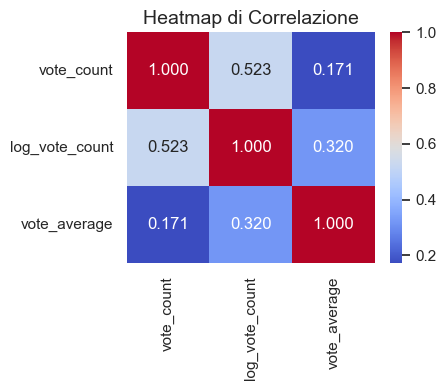

In [1792]:
corr = df[['vote_count', 'log_vote_count', 'vote_average']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Heatmap di Correlazione', fontsize=14)
plt.show()

L'aumento della correlazione da 0.171 a 0.320 è la prova quantitativa del successo della trasformazione logaritmica. La nuova feature log_vote_count è un predittore lineare molto più forte e affidabile per vote_average rispetto alla sua controparte originale.


In [1793]:
df = df.drop(['vote_count'], axis=1)

### Feature "popularity"

stesso approccio di vote_count

In [1794]:
df['popularity'].describe()

count    8549.000000
mean        8.241281
std        11.212910
min         1.805100
25%         3.751500
50%         5.086000
75%         8.434000
max       318.781200
Name: popularity, dtype: float64

In [1795]:
df['log_popularity'] = np.log1p(df['popularity'])

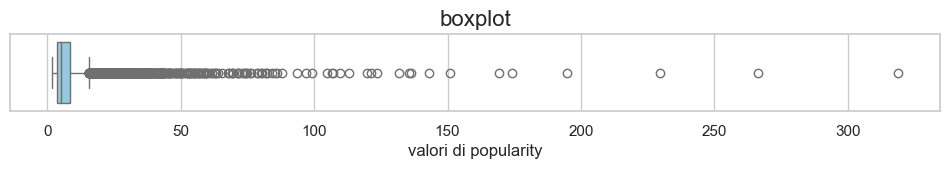

In [1796]:
plt.figure(figsize=(12, 1))
sns.boxplot(x=df['popularity'], color='skyblue')
plt.title('boxplot', fontsize=16)
plt.xlabel('valori di popularity')
plt.show()

analizzando la correlazione:

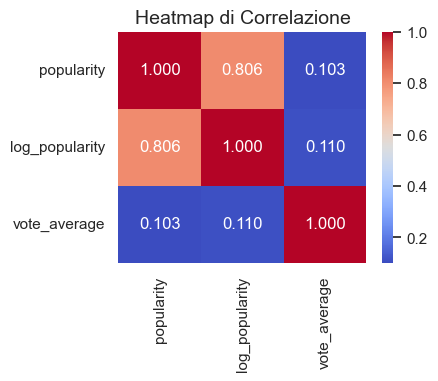

In [1797]:
corr = df[['popularity', 'log_popularity', 'vote_average']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Heatmap di Correlazione', fontsize=14)
plt.show()

osservazioni:
- anche qui assimetria verso destra dei valori
- forte presenza di outlier
- correlazione sostanzialmente invariata
- utilizziamo anche qui la trasformazione logaritmica

In [1798]:
df = df.drop(['popularity'], axis=1)

### Feature "overview"

In [1799]:
df['overview'].isnull().sum()

np.int64(0)

In [1800]:
import re

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() # convertireere tutti i caratteri in minuscolo
    text = re.sub(r'[^\w\s]', '', text) # rimuovere la punteggiatura
    return text

In [1801]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    preprocessor=preprocess_text,
    stop_words='english', # rimuovere le parole comuni inglesi
    max_features=100, # limitare il numero di feature alle 100 parole più importanti
    ngram_range=(1, 1) # considerare solo parole singole
)

In [1802]:
tfidf_matrix = vectorizer.fit_transform(df['overview'])

In [1803]:
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out() # per ottenere i nomi delle feature
)
tfidf_df = tfidf_df.add_prefix('tfidf_') # perfisso per queste colonne (più o meno come fatto per le altre feature

In [1804]:
print(tfidf_df.head())

   tfidf_adventures  tfidf_aired  tfidf_american  tfidf_based  tfidf_begins  \
0               0.0          0.0             0.0          0.0           0.0   
1               0.0          0.0             0.0          0.0           0.0   
2               0.0          0.0             0.0          0.0           0.0   
3               0.0          0.0             0.0          0.0           0.0   
4               0.0          0.0             0.0          0.0           0.0   

   tfidf_best  tfidf_boy  tfidf_broadcast  tfidf_called  tfidf_characters  \
0         0.0        0.0              0.0           0.0               0.0   
1         0.0        0.0              0.0           0.0               0.0   
2         0.0        0.0              0.0           0.0               0.0   
3         0.0        0.0              0.0           0.0               0.0   
4         0.0        0.0              0.0           0.0               0.0   

   ...  tfidf_tv  tfidf_war  tfidf_way  tfidf_wife  tfidf_woma

In [1805]:
# unione risultati
df = df.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)
df = pd.concat([df, tfidf_df], axis=1)
df = df.drop('overview', axis=1)

# Riepilogo

1. Rimozione di feature irrilevanti.
2. Alcuni dati critici mancanti ("overview") sono stati recuperati utilizzando le API di TMDB e OMDb per preservare la maggior parte del dataset. La stessa operazione poteva essere svolta anche per altre feature ma i valori mancanti erano pochissimi e per semplicità sono state eliminate quelle poche righe.
2. La variabile target "vote_average" è stata analizzata, rivelando che i valori pari a 0 corrispondevano a show senza voti. Queste righe (463) sono state rimosse per evitare di addestrare il modello su dati non informativi e rumorosi.
3. Le feature complesse come "genre_ids", "origin_country" e "original_language" sono state analizzate ed è stata adottata una strategia di one-hot encoding per catturare l'impatto delle categorie più rilevanti (Top-10 generi, Top-5 paesi, Top-10 lingue) per evitare eccessiva dimensionalità.
4. Da "first_air_date" è stata estratta la feature "release_year", che ha mostrato una correlazione positiva con il "vote_average".
5. Le feature "vote_count" e "popularity", caratterizzate da una forte asimmetria, sono state trasformate con una funzione logaritmica per normalizzare la loro distribuzione.
6. L'informazione testuale contenuta in "overview" è stata trasformata in un set di feature numeriche utilizzando la tecnica TF-IDF. Sono state estratte le 100 parole più significative, creando 100 nuove feature.

Risultato:
- DataFrame completamente numerico, pulito e privo di valori mancanti
- trade-off tra dimensionalità e aggiunta/recupero informazioni

In [1809]:
import os
df.to_csv(os.getcwd() +'/data/cleaned.csv', index=False, encoding='utf-8')